# Сравнение оценок и эффективные оценки. Задача 2


__Ильичёв А.С., 693__

In [15]:
import numpy as np
import scipy.stats as sts
from matplotlib import pyplot as plt
%matplotlib inline

#### 1. Сгенерируем выборки $X_1, \dots, X_N, N = 1000$ из распределений в теоретических задачах. Неизвестный параметр выберем случайно из распределения $\mathrm{Beta}(2,3)$.

In [16]:
N = 1000
ns = np.arange(1, N + 1)

In [17]:
beta_distr = sts.beta(2, 3)

а) Биномиальное распределение.

In [18]:
m = 50
p = beta_distr.rvs()
print(p)

0.5439786426329867


In [19]:
binom_distr = sts.binom(m, p)
binom_sample = binom_distr.rvs(N)

б) Экспоненциальное распределение.

In [20]:
theta = beta_distr.rvs()
print(theta)

0.23302307061687172


In [21]:
exp_distr = sts.expon(scale = 1 / theta)
exp_sample = exp_distr.rvs(N)

в) Нормальное распределение.

In [22]:
sigma2 = 2.1
a = beta_distr.rvs()
print(a)

0.2948187249255767


In [23]:
norm_distr = sts.norm(a, np.sqrt(sigma2))
norm_sample = norm_distr.rvs(N)

#### 2. Для всех $n \le N$ посчитаем значение эффективной оценки  и бутстрепную оценку дисперсии для эффективной оценки (параметрический бутстреп). Сделаем то же самое с другой несмещенной оценкой, а также посчитаем информацию Фишера.

Функции для подсчета оценки по выборке и бутстрепной оценки дисперсии возьмем из задачи 3.1.

In [24]:
def calculate_estimator(sample, first_func, second_func=None):
    est = np.array([first_func(sample[:i]) for i in ns])
    if second_func:
        est2 = np.array([second_func(sample[:i]) for i in ns])
        ests = [est, est2]
    else:
        ests = [est]
    return ests

# число бутстрепных выборок
straps_num = 500
# номер n, с которого начинается подсчет
start_from = 20
def bootstrap(parametric, distr, distr_sample, ests, grid_step, 
              parametric_distr, first_func, second_func=None):
    ns_strap = np.arange(max(start_from, grid_step), N + 1, grid_step)
    var_strap1 = [None] * len(ns_strap)
    var_strap2 = [None] * len(ns_strap)
    for i, n in enumerate(ns_strap):
        # генерируем N бутстрепных выборок размера n
        if not parametric:
            samples = np.random.choice(distr_sample[:n], size=(straps_num, n))
        else:                 
            if second_func: # если функция задана, то распределение 
                            # двухпараметрическое
                samples = parametric_distr(ests[0][n - 1], 
                               ests[1][n - 1]).rvs(size=(N, n))
            else: # однопараметрическое распределение
                samples = parametric_distr(ests[0][n - 1]).rvs(size=(straps_num, n))
        if second_func:
                # считаем оценку второго параметра и ее дисперсию для бутстрепной
                # выборки
                ests_strap2 = np.array([second_func(sample) for sample in samples])
                var_strap2[i] = np.mean(ests_strap2**2) - (np.mean(ests_strap2))**2
        # считаем оценку первого параметра и ее дисперсию для бутстрепной выборки
        ests_strap1 = np.array([first_func(sample) for sample in samples])
        var_strap1[i] = np.mean(ests_strap1**2) - (np.mean(ests_strap1))**2
    return [ns_strap, (var_strap1, var_strap2)]

Функция построения графиков (в данной задаче мы игнорируем `var_strap2`, потому что все оцениваемые параметры одномерные)

In [30]:
def make_plot(var_strap, fisher):
    plt.figure(figsize=(10, 5))
    plt.plot(var_strap[0], var_strap[1][0], alpha=0.7,
             label = 'оценка дисперсии параметрическим бутстрепом')
    plt.plot(ns[start_from:], 1 / fisher, 
             label = r'$1/ I_X(\theta)$', alpha=0.7)
    plt.title(r'Зависимость бутстрепной оценки дисперсии '
              r'оценки $\theta$ и обратной информации Фишера от $n$')
    plt.legend()
    plt.show()

а) Биномиальное распределение.

Эффективная оценка $p^* = \overline X / m$, информация Фишера $\frac{mn}{p(1 - p)}$, другая оценка $X_1/m$

Для эффективной оценки


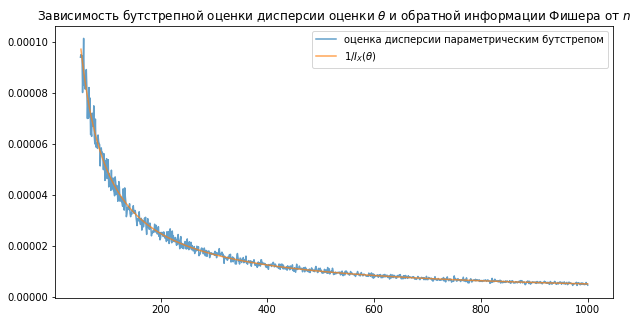

Для второй оценки


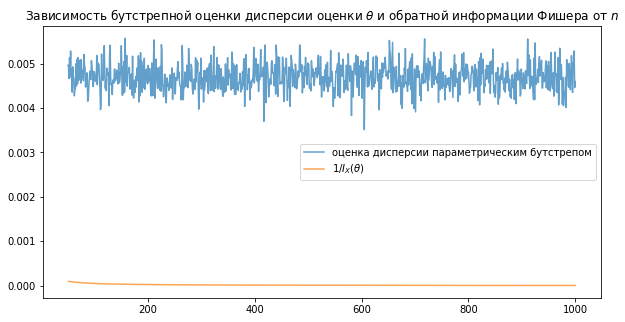

In [31]:
p_eff = lambda x: np.mean(x) / m
p_other = lambda x: x[0] / m

start_from = 50

def parametric_distr(param2):
    # оценка m может получаться нецелой
    return sts.binom(m, param2)

ests_eff = calculate_estimator(binom_sample, p_eff)
ests_other = calculate_estimator(binom_sample, p_other)
fisher_binom = np.array([ m * n /  (p * (1 - p))  for n in ns[start_from:]])

var_binom_eff = bootstrap(parametric=True, distr=sts.binom, 
                      distr_sample=binom_sample, ests=ests_eff, grid_step=1,
                      first_func=p_eff, parametric_distr=parametric_distr)
var_binom_other = bootstrap(parametric=True, distr=sts.binom, 
                      distr_sample=binom_sample, ests=ests_other, grid_step=1,
                      first_func=p_other, parametric_distr=parametric_distr)
print('Для эффективной оценки')
make_plot(var_binom_eff, fisher_binom)
print('Для второй оценки')
make_plot(var_binom_other, fisher_binom)

Вторая оценка не зависит от размера выборки (первый элемент для всех $n$ одинаковый), поэтому логично, что дисперсия оценки не меняется с увеличением $n$.

б) Экспоненциальное распределение  $\mathrm{Exp}(\theta)$.  

В случае этого распределения не существует эффективной оценки для $\theta$, поэтому будем оценивать $1/\theta$. В этом случае неравенство Рао-Крамера имеет вид 

$$\mathrm{D}_\theta \hat\theta(X) \ge \frac{\left(\tau'(\theta)\right)^2}{I_x(\theta)}$$

Итак, эффективная оценка $(1/\theta)^* = \overline X$, информация Фишера $\frac{n}{\theta^2}$, нижняя граница нер-ва $\frac1{n\theta^2}$, вторая оценка $\frac{n-1}{n\overline X}$. Но вторая оценка является несмещенной (и состоятельной) для $\theta$, а мы оцениваем $1/\theta$. Исправим ее, взяв $\frac{n\overline X}{n-1}$. Так мы получим состоятельную оценку для  $1/\theta$, не являющуюся, однако, несмещенной, так что нер-во Рао-Крамера для нее не обязано выполняться.

Для эффективной оценки


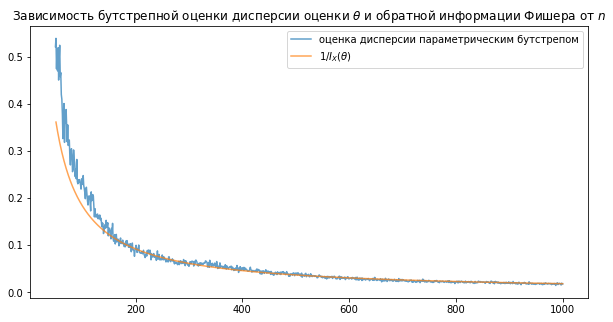

Для второй оценки


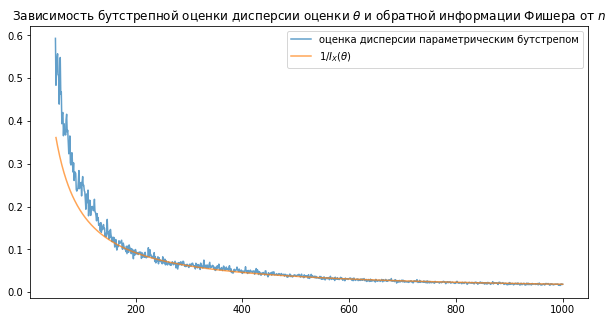

In [32]:
l_eff = lambda x: np.mean(x)
l_other = lambda x: len(x) * np.mean(x) / (len(x) - 
                                           1) if len(x) > 1 else 0

start_from = 50

def parametric_distr(param2):
    # оценка m может получаться нецелой
    return sts.expon(scale = param2)

ests_eff = calculate_estimator(exp_sample, l_eff)
ests_other = calculate_estimator(exp_sample, l_other)
# здесь еще учтен множитель 1/tau'^2 
fisher_exp = np.array([(n * theta**2)  for n in ns[start_from:]])

var_exp_eff = bootstrap(parametric=True, distr=sts.expon, 
                      distr_sample=exp_sample, ests=ests_eff, grid_step=1,
                      first_func=l_eff, parametric_distr=parametric_distr)
var_exp_other = bootstrap(parametric=True, distr=sts.expon, 
                      distr_sample=exp_sample, ests=ests_other, grid_step=1,
                      first_func=l_other, parametric_distr=parametric_distr)
print('Для эффективной оценки')
make_plot(var_exp_eff, fisher_exp)
print('Для второй оценки')
make_plot(var_exp_other, fisher_exp)

в) Нормальное распределение.  

Эффективная оценка $p^* = \overline X$, информация Фишера $\frac{n}{\sigma^2}$, другая оценка $\hat\mu$ - выборачная медиана.

Для эффективной оценки


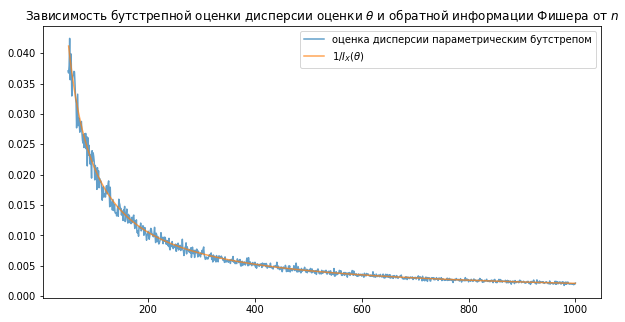

Для второй оценки


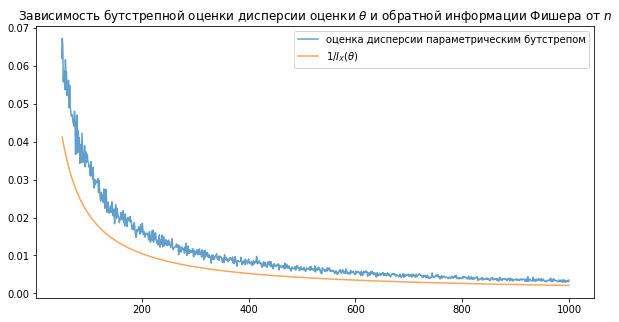

In [33]:
a_eff = lambda x: np.mean(x)
a_other = lambda x: np.median(x)

start_from = 50

def parametric_distr(param1):
    # оценка m может получаться нецелой
    return sts.norm(param1, np.sqrt(sigma2))

ests_eff = calculate_estimator(norm_sample, a_eff)
ests_other = calculate_estimator(norm_sample, a_other)

fisher_norm = np.array([(n / sigma2)  for n in ns[start_from:]])

var_norm_eff = bootstrap(parametric=True, distr=sts.norm, 
                      distr_sample=norm_sample, ests=ests_eff, grid_step=1,
                      first_func=a_eff, parametric_distr=parametric_distr)
var_norm_other = bootstrap(parametric=True, distr=sts.norm, 
                      distr_sample=norm_sample, ests=ests_other, grid_step=1,
                      first_func=a_other, parametric_distr=parametric_distr)
print('Для эффективной оценки')
make_plot(var_norm_eff, fisher_norm)
print('Для второй оценки')
make_plot(var_norm_other, fisher_norm)

#### Вывод.

Бутстрепная оценка дисперсии эффективной оценки для всех распределений почти совпадает с графиком правой части в неравенстве Рао-Крамера. Для эффективной оценки по определению должно быть выполнено равенство (между правой частью и дисперсией оценки). Из этого делаем вывод, что бутстрепная оценка дисперсии с высокой точностью приближает саму дисперсию, по крайней мере для эффективных оценок параметра. В распределениях а) и в) вторая несмещенная оценка, не являющаяся эффективной, имеет бутстрепную оценку дисперсии, большую $\frac1{I_x(\theta)}$. Истинная дисперсия для этих оценок в силу неравенства Рао-Крамера тоже должна быть больше. Можно поэтому предположить, что даже для неэффективных оценок бутстрепная оценка дисперсии хорошо приближает истинную. В распределении (б) для второй оценки условия теоремы Рао-Крамера не выполнены, однако при больших $n$ вторая оценка слабо отличается от эффективной, поэтому и графики оценок их дисперсий похожи.